[![Binder](https://mybinder.org/badge_logo.svg)](https://nbviewer.org/github/Sistemas-Multimedia/Sistemas-Multimedia.github.io/blob/master/milestones/10-ME/farneback_ME.ipynb)

# Farnebäck's motion estimation

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes as ax
plt.rcParams['text.usetex'] = True
#plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command

import pylab
import math
import numpy as np
from scipy import signal
import cv2
import os

!ln -sf ~/MRVC/src/image_3.py .
import image_3 as frame
!ln -sf ~/MRVC/src/YCoCg.py .
import YCoCg as YUV
!ln -sf ~/MRVC/src/debug.py .
!ln -sf ~/MRVC/src/motion.py .
!ln -sf ~/MRVC/src/config.py .
import motion
from common import show_frame
from common import show_vectors
from common import normalize
!ln -sf ~/quantization/information.py .
import information

OFCA: default number of levels = 3
OFCA: default window size = 33x33
OFCA: default number of iterations = 3
OFCA: extension mode = 1
OFCA: default poly_n 7
OFCA: default poly_sigma 1.5


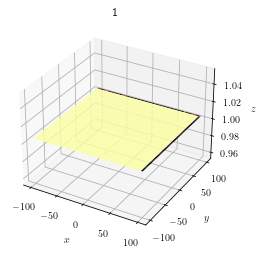

In [2]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = np.sin(tau)**2+np.cos(tau)**2+0.005
ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'1')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp,cmap=cm.inferno)
#fig.colorbar(surf)

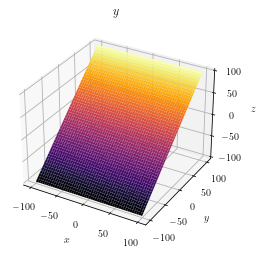

In [3]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = phi

ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'$y$')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp, cmap=cm.inferno)
#fig.colorbar(surf)

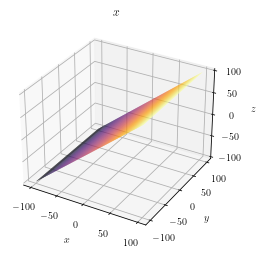

In [4]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = tau

ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'$x$')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp,cmap=cm.inferno)
#fig.colorbar(surf)

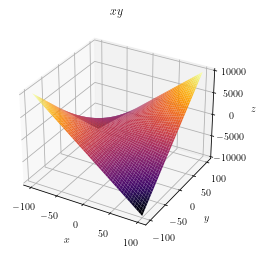

In [5]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = tau*phi

ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'$xy$')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp,cmap=cm.inferno)
#fig.colorbar(surf)

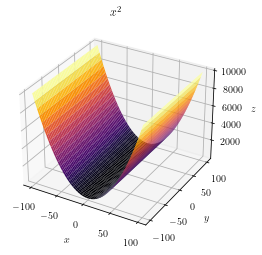

In [6]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = tau*tau

ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'$x^2$')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp,cmap=cm.inferno)
#fig.colorbar(surf)

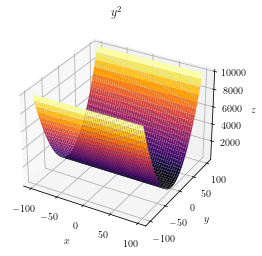

In [7]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid instead of np.tile
xs = np.linspace(-100, 100, 200)
ys = np.linspace(-100, 100, 200)
tau, phi = np.meshgrid(xs, ys) 
# Z evaluation
amp = phi*phi

ax3d.set_xlabel(r'$x$')  # tau = omega*t -> adimensional time
ax3d.set_ylabel(r'$y$')  # phi -> phase
ax3d.set_zlabel(r'$z$')   # signal amplitude
ax3d.set_title(r'$y^2$')   # signal amplitude

surf = ax3d.plot_surface(tau, phi, amp,cmap=cm.inferno)
#fig.colorbar(surf)

In [8]:
def normalize_(img):
    max_component = np.max(img)
    min_component = np.min(img)
    max_min_component = max_component - min_component
    return (img-min_component)/max_min_component

def show_frame_(frame, prefix=None):
    #frame = normalize(frame)
    plt.figure(figsize=(10,10))
    plt.title(prefix, fontsize=10)
    plt.imshow(frame)

def show_vectors2_(flow, dpi=150, downsampling=1):
    #plt.figure.set_dpi(200)
    plt.figure(dpi=dpi)
    plt.quiver(flow[..., 0][::downsampling], flow[..., 1][::downsampling])
    plt.show()
    
def show_vectors_(flow, dpi=150):
    #plt.figure.set_dpi(200)
    plt.figure(dpi=dpi)
    plt.quiver(flow[..., 0][::-1], flow[..., 1])
    plt.show()

In [9]:
R = YUV.from_RGB(frame.read("/home/vruiz/MRVC/sequences/moving_circles/", 0).astype(np.int16))[...,0]
P = YUV.from_RGB(frame.read("/home/vruiz/MRVC/sequences/moving_circles/", 1).astype(np.int16))[...,0]

image_3.read: /home/vruiz/MRVC/sequences/moving_circles/000.png image_3.read: Unable to read "/home/vruiz/MRVC/sequences/moving_circles/000.png"


error: OpenCV(4.5.4) /tmp/pip-req-build-9vck9bv0/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
show_frame(R, "Reference")

In [ ]:
show_frame(P, "Predicted")

The top circle moves to the right and the bottom circle moves to the left. Therefore, if we want to generate the predicted frame (bottom) from the reference one (top), all the top MVs (Motion Vectors) related to the circle should be (x=1, y=0), and all the bottom MVs (-1, 0).

In [ ]:
initial_MVs = np.zeros((P.shape[0], P.shape[1], 2), dtype=np.float32)
MVs = motion.estimate(predicted=P, reference=R, initial_MVs=initial_MVs)

In [ ]:
show_vectors(MVs[::1, ::1])

In [ ]:
hat_P = motion.make_prediction(reference=R, MVs=MVs)

In [ ]:
show_frame(R, "reference ${\mathbf R}$")

In [ ]:
show_frame(hat_P, "prediction $\hat{\mathbf P}$")

In [ ]:
show_frame(P.astype(np.int16)-hat_P, "prediction error ($P-\hat{P}$)")

## Even more distance

In [ ]:
R = YUV.from_RGB(frame.read("/home/vruiz/MRVC/sequences/moving_circles/", 0).astype(np.int16))[...,0]
P = YUV.from_RGB(frame.read("/home/vruiz/MRVC/sequences/moving_circles/", 4).astype(np.int16))[...,0]

In [ ]:
show_frame(R, "reference ${\mathbf R}$")
show_frame(P, "predicted ${\mathbf P}$")

In [ ]:
initial_MVs = np.zeros((P.shape[0], P.shape[1], 2), dtype=np.float32)
MVs = motion.estimate(predicted=P, reference=R, initial_MVs=initial_MVs)

In [ ]:
show_vectors(MVs[::1, ::1])

In [ ]:
hat_P = motion.make_prediction(R, MVs)
show_frame(hat_P, "prediction $\hat{\mathbf P}$")
show_frame(P-hat_P, "prediction error")

## Tile of stockholm

In [ ]:
prefix = "/home/vruiz/MRVC/sequences/stockholm/"
R = frame.read(prefix, 0)[100:356, 100:612]
P = frame.read(prefix, 1)[100:356, 100:612]
R_Y = YUV.from_RGB(R.astype(np.int16))[..., 0]
P_Y = YUV.from_RGB(P.astype(np.int16))[..., 0]
show_frame(R, "${\mathbf R}$")
show_frame(P, "${\mathbf P}$")

In [ ]:
initial_MVs = np.zeros((P.shape[0], P.shape[1], 2), dtype=np.float32)
MVs = motion.estimate(predicted=P_Y, reference=R_Y, initial_MVs=initial_MVs)

In [ ]:
entropy = information.entropy(MVs.flatten())
show_vectors(MVs[::10, ::10], title="${\mathbf V}$ (Farnebäck) " + f"entropy={entropy:1.2f} bits/component" + f", {MVs.size} components")

In [ ]:
hat_P = motion.make_prediction(R, MVs)
show_frame(hat_P, "$\hat{\mathbf P}$ (Farnebäck)")
P_hat_P = P - hat_P + 128
entropy = information.entropy(P_hat_P.flatten())
show_frame(P_hat_P, "${\mathbf P}$ - $\hat{\mathbf P}$ (Farnebäck)" + f" entropy={entropy:1.2f} bits/pixel")